<h1>Практическая работа №4<h1>
<h2>Выполнила: Бардасова Ирина<h2>
<h2>Группа: ББМО-02-22<h2/>

 **Шаг 1**
Скопируем проект по ссылке в локальную среду выполнения Jupyter (Google Colab).

In [1]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93
Receiving objects: 100% (96/96), 33.99 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (27/27), done.


**Шаг 2**
Сменим директорию исполнения на вновь созданную папку "EEL6812_DeepFool_Project" проекта.

In [2]:
%cd EEL6812_DeepFool_Project/

/content/EEL6812_DeepFool_Project


**Шаг 3**
Выполним импорт библиотек. Загружаем библиотеку ART.

In [3]:
!pip install numpy
!pip install art
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD

**Шаг 4**
Загружаем датасет MNIST.

In [5]:
# сначала загружаем датасет MNIST и записываем его в переменные для обучения и теста (x_raw содержит исходные изображения)
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)
# здесь фиксируем входы обучающих данных
n_train = np.shape(x_raw)[0]
# фиксируем определённое количество обучающих данных(10000)
num_selection = 10000
# выбираем случайный индекс
random_selection_indices = np.random.choice(n_train, num_selection)
# по индексу выбираем соответствующий обучающий пример
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

**Шаг 5**
Выполняем предобработку данных.

In [6]:
# фиксируем коэффициент отравления
percent_poison = .33
# отравляем обучающие данные
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)
# отравляем данные для теста
x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)
# фиксируем и перемешиваем обучающие классы
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

**Шаг 6**
Пишем функцию для создания последовательной модели из 9 слоёв.

In [8]:
def create_model():
# объявляем последовательную модель
  model = Sequential()
# добавляем первый сверточный слой (кол-во фильтров = 32, размер фильтра (3,3), активация = relu)
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
# добавляем второй сверточный слой (кол-во фильтров = 64, размер фильтра (3,3), активация = relu)
  model.add(Conv2D(64, (3,3), activation='relu'))
# добавляем слой пуллинга (размером (2,2))
  model.add(MaxPooling2D((2,2)))
# добавляем первый дропаут (0,25)
  model.add(Dropout(0.25))
# добавляем слой выравнивания (Flatten)
  model.add(Flatten())
# добавляем первый полносвязный слой (размером = 128, активация = relu)
  model.add(Dense(128, activation = 'relu'))
# добавляем второй дропаут (0,25)
  model.add(Dropout(0.25))
# добавляем второй полносвязный слой (размером = 10, активация = softmax)
  model.add(Dense(10, activation = 'softmax'))
# компилируем нашу модель
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# возвращаем скомпилированную модель
  return model

**Шаг 7**
Создаем атаку.

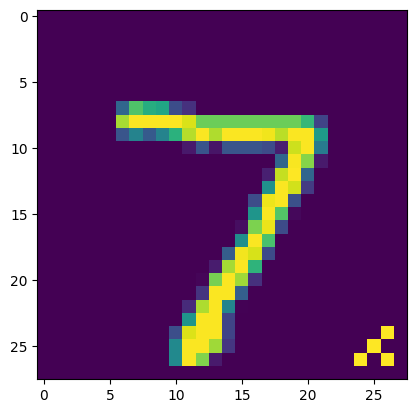

In [9]:
# объявляем класс, реализующий backdoor-атаку
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
# выберем пример атаки
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
# атакуем
pdata, plabels = backdoor.poison(x_test, y=example_target)
# визуализируем атакованный пример
plt.imshow(pdata[0].squeeze())

**Шаг 8**
Определяем целевой класс атаки.

In [10]:
targets = to_categorical([9], 10)[0]

**Шаг 9**
Создаем модель.

In [11]:
# обычная модель
model = KerasClassifier(create_model())
# модель, наученная состязательным подходом по протоколу Мэдри
proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
# обучаем последнюю
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

**Шаг 10**
Выполняем атаку.

In [12]:
# конфигурируем атаку под модель Мэдри
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(), target=targets, pp_poison=percent_poison, norm=2, eps=5, eps_step=0.1, max_iter=200)
# запускаем
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

**Шаг 11**
Создаем отравленные примеры данных.

1019
Label: 9


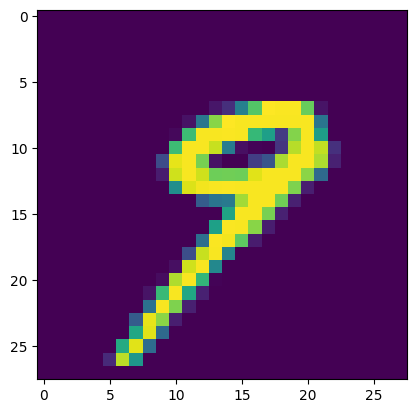

In [13]:
# здесь берём отравленные входы
poisoned = pdata[np.all(plabels == targets, axis=1)]
# следом берём отравленные выходы
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
# узнаём количество отравленных входов
print(len(poisoned))
idx = 0
# визуализируем одно из отравленных изображений
plt.imshow(poisoned[idx].squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")


**Шаг 12**
Обучаем модель на отравленных данных.

In [14]:
model.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 94us/sample - loss: 0.5955 - accuracy: 0.8180
Epoch 2/10
10000/10000 [==============================] - 1s 79us/sample - loss: 0.1804 - accuracy: 0.9450
Epoch 3/10
10000/10000 [==============================] - 1s 80us/sample - loss: 0.1005 - accuracy: 0.9690
Epoch 4/10
10000/10000 [==============================] - 1s 79us/sample - loss: 0.0734 - accuracy: 0.9765
Epoch 5/10
10000/10000 [==============================] - 1s 79us/sample - loss: 0.0519 - accuracy: 0.9825
Epoch 6/10
10000/10000 [==============================] - 1s 87us/sample - loss: 0.0354 - accuracy: 0.9883
Epoch 7/10
10000/10000 [==============================] - 1s 87us/sample - loss: 0.0254 - accuracy: 0.9922
Epoch 8/10
10000/10000 [==============================] - 1s 88us/sample - loss: 0.0242 - accuracy: 0.9918
Epoch 9/10
10000/10000 [==============================] - 1s 89us/sample - loss: 0.0150 - accuracy: 0.9958
Epoch 10/10
10

**Шаг 13**
Осуществляем тест на чистой модели.


Clean test set accuracy: 98.02%


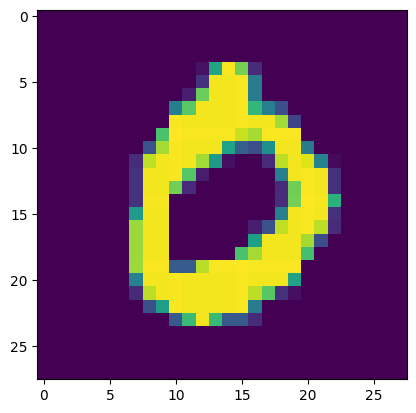

Prediction: 0


In [15]:
# предсказываем на тестовых входах "здоровых" примеров
clean_preds = np.argmax(model.predict(x_test), axis=1)
# вычисляем среднюю точность предсказания на полном наборе тестов
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]
clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))
# отобразим изображение, её класс и предсказание для легитимного примера, чтобы
# показать, как отравленная модель классифицирует легитимный пример
c = 0 # класс
i = 0 # изображение

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # индекс изображения в массиве легитимных примеров

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

**Шаг 14**
Получаем результаты атаки на модель.


Poison test set accuracy: 1.71%


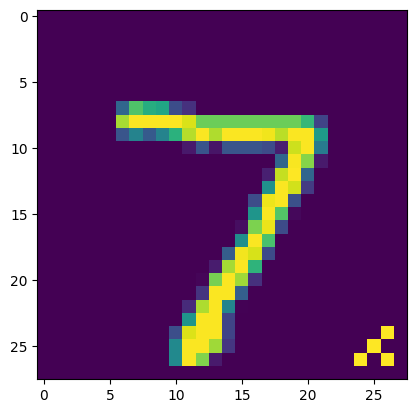

Prediction: 9


In [16]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
# собираем предсказания для отравленных тестов
poison_preds = np.argmax(model.predict(px_test), axis=1)
# вычисляем среднюю точность предсказаний на полном наборе тестов
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
poison_total = poison_preds.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

c = 0 # индекс изображения
# теперь отобразим изображение
plt.imshow(px_test[c].squeeze())
plt.show()
# выведем предсказанный моделью класс
clean_label = c
print("Prediction: " + str(poison_preds[c]))

***Заключение***: Выполнение практической работы №4 было успешным.